# Baseline Classifier - Training
## Introduction

This notebook is an attempt to train a baseline neuralnetwork to the task of American Sign Language detection for the DSPRO2 project at HSLU.

In [7]:
!pip install fiftyone kornia

In [3]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [35]:
import torch
import torch.nn as nn
import torchvision.models 
import torchvision.transforms as transforms

from datapipeline.asl_landmarks_data_module import ASLLandmarksDataModule
from lightning.pytorch.loggers import WandbLogger
from models.asl_model import ASLModel
from models.training import train, PROJECT_NAME, ENTITY_NAME

In [47]:
import wandb
import torch
import torch.nn as nn
import torchvision.models as visionmodels
import torchvision.transforms.v2 as transforms
import lightning as L

from lightning.pytorch.loggers import WandbLogger

import nbformat

from typing import Callable

import os

# Our own modules
import models.sweep_helper as sweep_helper

from datapipeline.asl_landmarks_data_module import ASLLandmarksDataModule
from models.asl_model import ASLModel
from models.training import sweep, train_model

In [37]:
os.environ["WANDB_NOTEBOOK_NAME"] = "./dspro2/training_baseline.ipynb"

## Preprocessing

In [38]:
PATH = "/exchange/dspro2/silent-speech/ASL_Landmarks_Dataset"

In [39]:
datamodule = ASLLandmarksDataModule(path=PATH)

## Models

In [40]:
class BaselineNN(nn.Module):
    def __init__(self, input_size=63, num_classes=28):
        super(BaselineNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

## Training

In [48]:
sweep_config = {
    "method": "grid",
    "parameters": {
        "lr": {"values": [0.001, 0.01]},
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate_scheduler": {
            "values": [
                {"type": "step", "step_size": 10, "gamma": 0.1},
                {"type": "none"}
            ]
        }
    }
}


In [49]:
def get_model(config):
    model = BaselineNN(input_size=63, num_classes=28)
    test_input = torch.randn(4, 63)
    with torch.no_grad():
        out = model(test_input)
    print("Model output shape:", out.shape)
    return model


In [50]:
def get_optimizer(config, model):
    lr = config.get("lr", 1e-3)
    optimizer_type = config.get("optimizer", "adam").lower()
    if optimizer_type == "adam":
        return torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_type}")


In [55]:
def training_procedure():
    run = wandb.init()  # Correctly start run
    wandb.run.name = f"baseline-{run.id}"  # Set name

    config = wandb.config

    model = BaselineNN(input_size=63, num_classes=28)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    datamodule = ASLLandmarksDataModule(path="/exchange/dspro2/silent-speech/ASL_Landmarks_Dataset")

    asl_model = ASLModel(model=model, criterion=nn.CrossEntropyLoss(), optimizer=optimizer)

    train(model=asl_model, datamodule=datamodule, logger=WandbLogger(log_model=True))

    wandb.finish()


In [56]:

sweep(sweep_config, count=10, training_procedure=training_procedure)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/training_baseline.ipynb.


Create sweep with ID: lbb4rc1a
Sweep URL: https://wandb.ai/dspro2-silent-speech/silent-speech/sweeps/lbb4rc1a


wandb: Agent Starting Run: j4brp5tx with config:
wandb: 	learning_rate_scheduler: {'gamma': 0.1, 'step_size': 10, 'type': 'step'}
wandb: 	lr: 0.001
wandb: 	optimizer: adam
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/training_baseline.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | BaselineNN         | 5.9 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | valid_accuracy | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.971
Metric train_accuracy improved. New best score: 0.962


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.988


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.006 >= min_delta = 0.0. New best score: 0.994
Metric train_accuracy improved by 0.038 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.998
Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▇█▅▅█▇█▇█████▇▇██████▇████▇███████████
train_loss,█▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇███
valid_accuracy,▁▅▇▇████
valid_loss,█▃▂▂▁▁▁▁
epoch,7
lr-Adam,0.001


wandb: Agent Starting Run: pkjdx24n with config:
wandb: 	learning_rate_scheduler: {'gamma': 0.1, 'step_size': 10, 'type': 'step'}
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/training_baseline.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | BaselineNN         | 5.9 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | valid_accuracy | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.979
Metric train_accuracy improved. New best score: 0.962


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.992
Metric train_accuracy improved by 0.038 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.998
Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▇▇▇▇██▇████████████████████████████████
train_loss,█▃▃▂▂▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇███
valid_accuracy,▁▆▇████
valid_loss,█▃▂▂▁▁▁
epoch,6
lr-Adam,0.001


wandb: Agent Starting Run: b9e2el1v with config:
wandb: 	learning_rate_scheduler: {'gamma': 0.1, 'step_size': 10, 'type': 'step'}
wandb: 	lr: 0.01
wandb: 	optimizer: adam
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/training_baseline.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | BaselineNN         | 5.9 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | valid_accuracy | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.991
Metric train_accuracy improved. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▁▁▁▁▂▂▂▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▇▇▇▇▇███████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁█████████████████████████████▁█████████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██████
valid_accuracy,▁▆███▇
valid_loss,█▂▁▁▁▁
epoch,5
lr-Adam,0.01


wandb: Agent Starting Run: bni30thf with config:
wandb: 	learning_rate_scheduler: {'gamma': 0.1, 'step_size': 10, 'type': 'step'}
wandb: 	lr: 0.01
wandb: 	optimizer: sgd
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/training_baseline.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | BaselineNN         | 5.9 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | valid_accuracy | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.997
Metric train_accuracy improved. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇████████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▇▇█▇██████████████████████▇█▇██████████
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇█████
valid_accuracy,▁▆█▂██
valid_loss,█▃▁▆▁▁
epoch,5
lr-Adam,0.01


wandb: Agent Starting Run: kiatfvoe with config:
wandb: 	learning_rate_scheduler: {'type': 'none'}
wandb: 	lr: 0.001
wandb: 	optimizer: adam
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/training_baseline.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | BaselineNN         | 5.9 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | valid_accuracy | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.977
Metric train_accuracy improved. New best score: 0.962


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.0. New best score: 0.992
Metric train_accuracy improved by 0.038 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.005 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.999
Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▇▃▇▇▇▇█████████████████████████████████
train_loss,█▇▄▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇████
valid_accuracy,▁▆▇████
valid_loss,█▃▂▂▁▁▁
epoch,6
lr-Adam,0.001


wandb: Agent Starting Run: 1iebn6jj with config:
wandb: 	learning_rate_scheduler: {'type': 'none'}
wandb: 	lr: 0.001
wandb: 	optimizer: sgd
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/training_baseline.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | BaselineNN         | 5.9 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | valid_accuracy | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.975
Metric train_accuracy improved. New best score: 0.962


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 0.992
Metric train_accuracy improved by 0.038 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.004 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.998
Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▆▇▇▇▇▇█▇▇▇████████████████████████████
train_loss,█▅▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇██
valid_accuracy,▁▆▇▇███
valid_loss,█▃▂▁▁▁▁
epoch,6
lr-Adam,0.001


wandb: Agent Starting Run: 5e5ijju8 with config:
wandb: 	learning_rate_scheduler: {'type': 'none'}
wandb: 	lr: 0.01
wandb: 	optimizer: adam
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/training_baseline.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | BaselineNN         | 5.9 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | valid_accuracy | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.991
Metric train_accuracy improved. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.007 >= min_delta = 0.0. New best score: 0.998


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▁▁▁▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇████████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,█▁█▁███████████▁███████████▁████████████
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇████
valid_accuracy,▁▆███▇
valid_loss,█▂▁▁▁▁
epoch,5
lr-Adam,0.01


wandb: Agent Starting Run: f4hfx5yy with config:
wandb: 	learning_rate_scheduler: {'type': 'none'}
wandb: 	lr: 0.01
wandb: 	optimizer: sgd
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./dspro2/training_baseline.ipynb.


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | BaselineNN         | 5.9 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | valid_accuracy | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.997
Metric train_accuracy improved. New best score: 1.000


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.002 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.000 >= min_delta = 0.0. New best score: 0.999


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric train_accuracy did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


epoch,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇█████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-weight_decay,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,█▁██████████████████████████████████████
train_loss,▃█▁▂▁▁▁▂▁▁▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
trainer/global_step,▁▁▁▁▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
valid_accuracy,▁▆█▂██
valid_loss,█▃▁▆▁▁
epoch,5
lr-Adam,0.01


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Exception: Sweep already finished.


🧪 Test label distribution:
A: 19
B: 22
C: 14
D: 15
E: 24
F: 22
G: 22
H: 18
I: 21
J: 21
K: 27
L: 26
M: 20
N: 18
Nothing: 1
O: 16
P: 15
Q: 16
R: 22
S: 25
Space: 15
T: 22
U: 23
V: 22
W: 16
X: 22
Y: 26
Z: 21

🧪 Unique labels in test set: [np.str_('A'), np.str_('B'), np.str_('C'), np.str_('D'), np.str_('E'), np.str_('F'), np.str_('G'), np.str_('H'), np.str_('I'), np.str_('J'), np.str_('K'), np.str_('L'), np.str_('M'), np.str_('N'), np.str_('Nothing'), np.str_('O'), np.str_('P'), np.str_('Q'), np.str_('R'), np.str_('S'), np.str_('Space'), np.str_('T'), np.str_('U'), np.str_('V'), np.str_('W'), np.str_('X'), np.str_('Y'), np.str_('Z')]
✅ Expected class order: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Nothing']
✅ Evaluation complete.

              precision    recall  f1-score   support

           A       0.50      0.11      0.17        19
           B       1.00      0.18      0.31        22


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


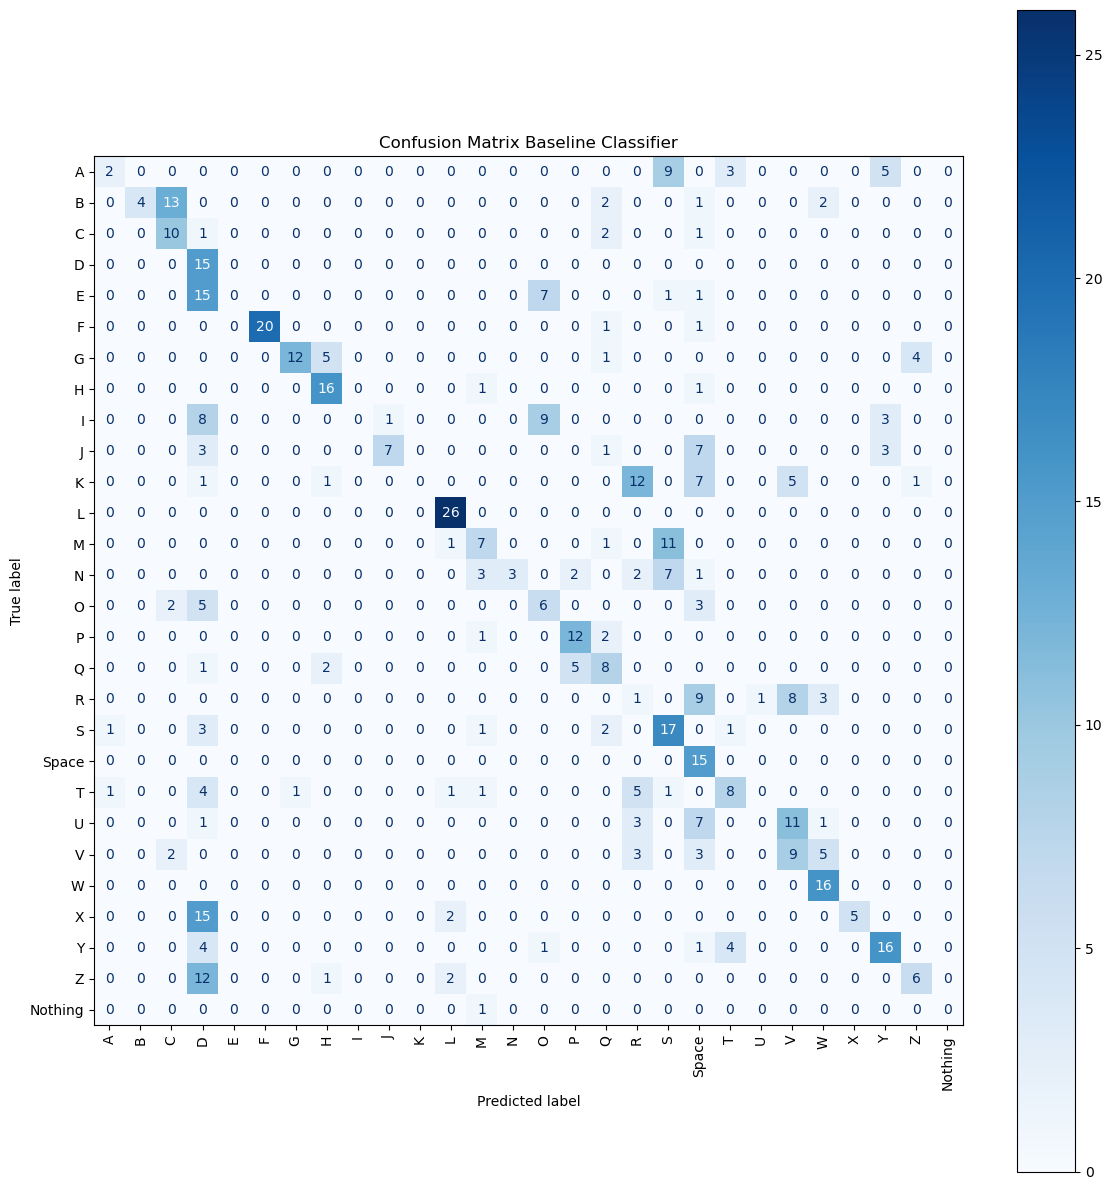

In [1]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ----- Load Lightning Checkpoint -----
ckpt_path = "baseline.ckpt"
checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
state_dict = {k.replace("model.", ""): v for k, v in checkpoint['state_dict'].items()}

# Create Sequential model
model = nn.Sequential(
    nn.Linear(63, 64),
    nn.ReLU(),
    nn.Linear(64, 28)
)
model.load_state_dict(state_dict)
model.eval()

# ----- Load and Prepare Test Data -----
data_dir = Path('/exchange/dspro2/silent-speech/Test_Images_Landmarks')
X_list, y_list = [], []

# Force loading order using class_order
class_order = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
    'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Nothing'
]
for label in class_order:
    x_file = data_dir / f"X_{label}.npy"
    y_file = data_dir / f"y_{label}.npy"
    if x_file.exists() and y_file.exists():
        X = np.load(x_file)
        y = np.load(y_file)

        
        X_list.append(X)
        y_list.append(y)

X_test = np.vstack(X_list)
y_test = np.concatenate(y_list)

# ----- Inspect Test Label Distribution -----
unique, counts = np.unique(y_test, return_counts=True)
print("\n🧪 Test label distribution:")
for label, count in zip(unique, counts):
    print(f"{label}: {count}")

# ----- Check for Label Alignment with Class Order -----
# class_order already defined above; no need to redefine it
print("\n🧪 Unique labels in test set:", sorted(set(y_test)))
print("✅ Expected class order:", class_order)

# ----- Manual Label Encoding to Match Training -----
le = LabelEncoder()
le.fit(class_order)
y_test_encoded = np.array([class_order.index(label) for label in y_test])

# ----- Predict -----
X_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    logits = model(X_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()

# ----- Classification Report -----
print("\u2705 Evaluation complete.\n")
print(classification_report(y_test_encoded, y_pred, target_names=class_order))

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test_encoded, y_pred)

# Reorder matrix to match A-Z, Space, Nothing
index_order = list(range(len(class_order)))  # class_order is already the correct order
cm_sorted = cm[np.ix_(index_order, index_order)]

# Plot reordered matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sorted, display_labels=class_order)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix Baseline Classifier")
plt.tight_layout()
plt.savefig("confusion_matrix_baseline.png", dpi=300)
plt.show()